In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from stardistPytorch.utils import normalize
from stardistPytorch.prediction import *
np.random.seed(6)
lbl_cmap = random_label_cmap()

# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [2]:
X = sorted(glob('data/dsb2018/test/images/*.tif'))
Y = sorted(glob('data/dsb2018/test/masks/*.tif'))
X = list(map(imread,X))
Y = list(map(imread,Y))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [3]:
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

In [4]:
model=torch.load('models/best_dsb_32_depth=3_2020-03-29 19:50:33.855115.net')

/home/lalit/Desktop/01_Softwares/anaconda3/envs/stardistPytorchEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [7]:
from stardistPytorch.utils import matching_dataset
img = normalize(X[0], 1, 99.8, axis=axis_norm)
labels, _ = predict(img, model, nms_thresh=0.25, prob_thresh=0.25)
score=matching_dataset([Y[0]], [labels], by_image=True)
print(score)

100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

DatasetMatching(criterion='iou', thresh=0.5, fp=4, tp=42, fn=11, precision=0.9130434782608695, recall=0.7924528301886793, accuracy=0.7368421052631579, f1=0.8484848484848485, n_true=53, n_pred=46, mean_true_score=0.606781042961927, by_image=True)


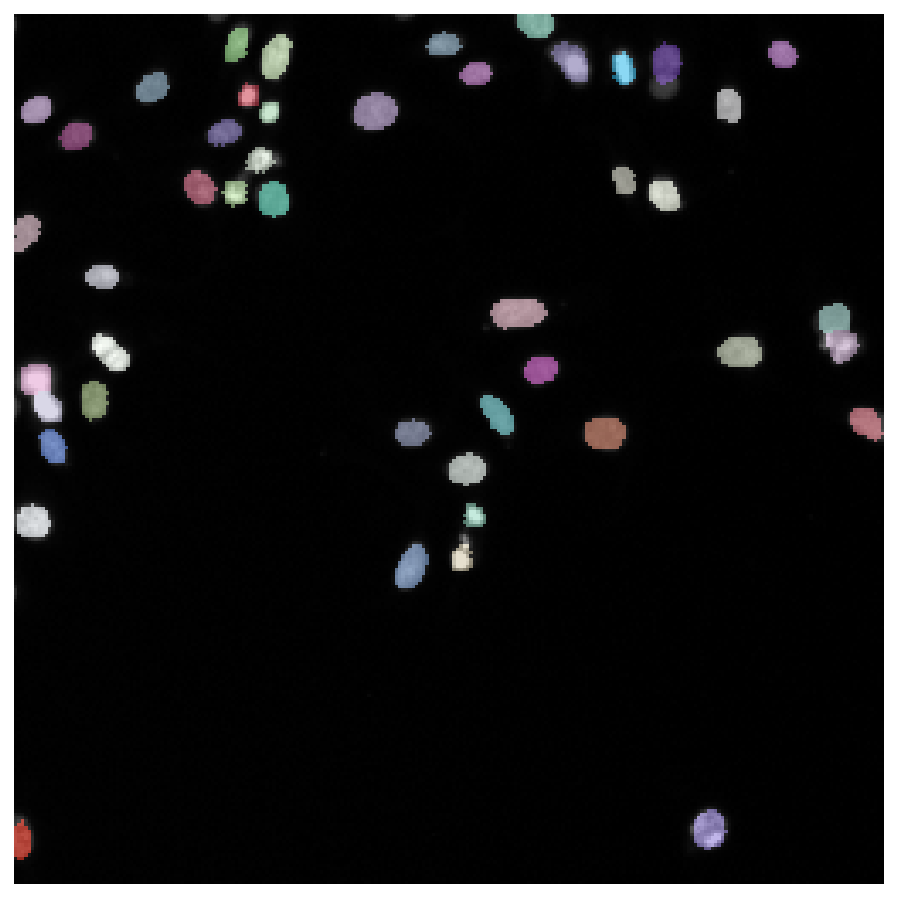

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

# Example results

In [8]:
from stardistPytorch.prediction import _draw_polygons

In [9]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    #labels, details = model.predict_instances(img)
    labels, details= predict(img, model)
    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, grid=(1,1), show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap='plasma', alpha=0.5)
    plt.tight_layout()
    plt.show()

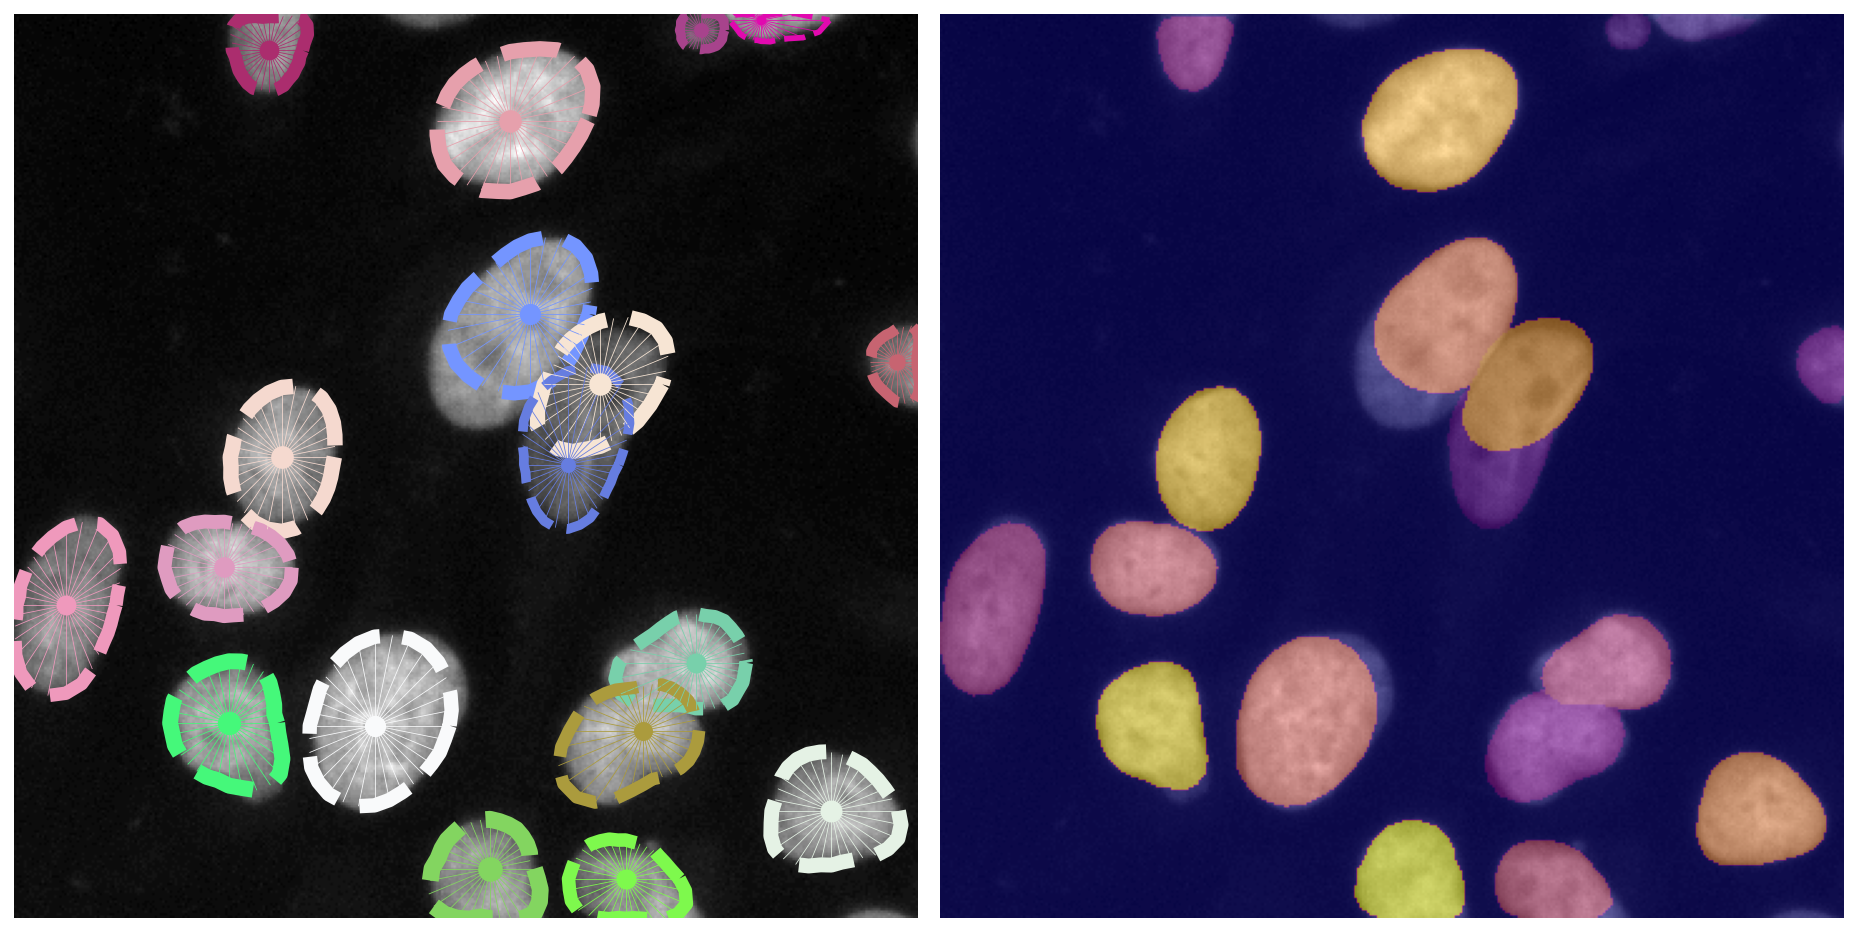

In [10]:
example(model, 42)

# Get Results

In [8]:
resultList=[]
for index, image in enumerate(X):
    img = normalize(image, 1,99.8, axis=axis_norm)
    labels, _ = predict(img, model, nms_thresh=0.2, prob_thresh=0.1)
    score=matching_dataset([Y[index]], [labels])
    resultList.append(score.accuracy)

100%|██████████| 1/1 [00:00<00:00, 145.95it/s]


In [9]:
np.average(resultList)

0.8358346081815305

# Model from paper

In [14]:
# model_paper = StarDist2D(None, name='2D_dsb2018', basedir='../../models/paper')

In [15]:
# example(model_paper, 42)